In [1]:
import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
import glob,os
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

from tqdm.keras import TqdmCallback
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8166799246774020136,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1934329154926470168
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10760062580903196027
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23250927616
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14034538211267121658
 physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [2]:
image_dir ='images/glow_resnet2/'
for f in glob.glob(image_dir+'*.png'):
    os.remove(f)

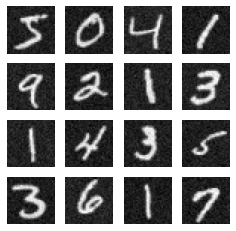

In [3]:
(train_images, train_labels), (validate_images,validate_labels) = tf.keras.datasets.mnist.load_data()
train_images =train_images.reshape([-1,28,28,1]).astype('float32')
train_images = tf.image.resize(train_images,[32,32])
images_shape = train_images.shape
train_images = train_images/255.0
train_images = train_images + tf.random.normal(images_shape,mean=0.0,stddev=5e-2)
fig = plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_images[i], cmap = 'gray')
    plt.axis('off')
    
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(None)

In [4]:
tfk = tf.keras
tfkl = tfk.layers
class GlowBlock(tfkl.Layer):
    def __init__(self,input_shape, num_hidden, kernel_shape):
        super(GlowBlock, self).__init__()
        
        this_nchan = input_shape[-1] * 2
        
        self.conv2a = tfkl.Conv2D(num_hidden, 
                                  kernel_size=kernel_shape, 
                                  padding='same',
                                  kernel_initializer=tf.initializers.he_normal(),
                                  activation='relu')

        self.conv2b = tfkl.Conv2D(num_hidden, 
                                  kernel_size=1, 
                                  padding='same',
                                  kernel_initializer=tf.initializers.he_normal())

        self.conv2c = tfkl.Conv2D(this_nchan, 
                                  kernel_size=kernel_shape, 
                                  padding='same',
                                  kernel_initializer=tf.initializers.zeros(),
                                  bias_initializer=tf.initializers.zeros())
        
        self.convSkip = tfkl.Conv2D(this_nchan,
                                    kernel_size=1,
                                    padding='same',
                                    kernel_initializer=tf.initializers.he_normal())

    def call(self, input_tensor):
        
        x = self.conv2a(input_tensor)
        x = self.conv2b(x)
        x = self.conv2c(x)
        x += self.convSkip(input_tensor)
    
        return tf.nn.relu(x)

class GlowResnet(tfk.Sequential):
    def __init__(self,input_shape,num_hidden=32,kernel_shape=3):
        super(GlowResnet,self).__init__([
            tfkl.Input(shape=input_shape),
            GlowBlock(input_shape,num_hidden=num_hidden,kernel_shape=kernel_shape),
            GlowBlock(input_shape,num_hidden=num_hidden,kernel_shape=kernel_shape),
            GlowBlock(input_shape,num_hidden=num_hidden,kernel_shape=kernel_shape),
            GlowBlock(input_shape,num_hidden=num_hidden,kernel_shape=kernel_shape)])
        

In [5]:
output_dim = 32*32
bijectors = []
glow_bijector = tfp.bijectors.Glow(
                output_shape=[32,32,1],
                num_glow_blocks = 3,
                num_steps_per_block=12,
                use_actnorm = True,
                coupling_bijector_fn=GlowResnet,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork)

ref_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(output_dim,tf.float32),
                                      scale_diag = tf.ones(output_dim,tf.float32))
flow = tfd.TransformedDistribution(distribution=ref_dist,
                                   bijector=glow_bijector)

In [6]:
@tf.function
def train_step(target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(flow.log_prob(target_sample))
    gradients = tape.gradient(loss,flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients,flow.trainable_variables))
    return loss

@tf.function
def sample(N):
    return tf.reshape(flow.sample(N),[-1,32,32])

def save_samples(epoch):
    images = sample(16)
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')
    plt.suptitle('epoch: %03d'%(epoch))
    plt.savefig(image_dir+'image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

def train(dataset,num_epochs):
        t = trange(num_epochs)
        for epoch in t:
            for batch in dataset:
                loss = train_step(batch)
                t.set_description("loss: %0.3f " % loss.numpy())
                t.refresh()
                loss_history.append(loss.numpy())
            save_samples(epoch)
        return None

In [7]:
loss_history = []
LR = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
train(train_dataset,200)

loss: 590.075 :   0%|          | 0/200 [01:00<?, ?it/s]  


KeyboardInterrupt: 

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
plt.plot(loss_history)
ysmoothed = gaussian_filter1d(loss_history, sigma=30)
plt.plot(ysmoothed,color='red')
plt.ylim(-2870,-2600)
plt.savefig(image_dir+'loss_plot.png')

In [ ]:
class GLOW(tf.keras.Model):
    
    def __init__(self,flow):
        super(GLOW,self).__init__()
        self.flow = flow
    
    @tf.function
    def call(self, inputs):
        return self.flow.bijector.forward(inputs)
    
    @tf.function
    def inverse(self,inputs):
        return self.flow.bijector.inverse(inputs)
    
    @tf.function
    def sample(self,N):
        return self.flow.sample(N)
    
    @tf.function
    def nll(self,inputs):
        return -tf.reduce_mean(flow.log_prob(target_sample))

    def compile(self,optimizer):
        super(GLOW, self).compile()
        self.optimizer = optimizer
        self.loss_fn = self.nll

In [ ]:
def plot_samples(model):
    images = model.sample(36)
    fig = plt.figure(figsize=(6,6))
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')
    plt.savefig(image_dir+'glow_samples.png')
    plt.pause(0.5)

In [ ]:
glow = GLOW(flow)
glow(tf.random.normal([1,output_dim]))
glow.summary()
model_path = 'models/glow_resnet2/'
glow.save_weights(model_path)

glow_bijector2 = tfp.bijectors.Glow(
                output_shape=[32,32,1],
                num_glow_blocks = 3,
                num_steps_per_block=8,
                use_actnorm = True,
                coupling_bijector_fn=GlowResnet,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork)

ref_dist2 = tfd.MultivariateNormalDiag(loc=tf.zeros(output_dim,tf.float32),
                                      scale_diag = tf.ones(output_dim,tf.float32))
flow2 = tfd.TransformedDistribution(distribution=ref_dist2,
                                   bijector=glow_bijector2)
glow_new = GLOW(flow2)
glow_new.load_weights(model_path)
plot_samples(glow_new)